# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math
import json
import tqdm
from time import time
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Task Setting

For this project, I want to build a ML model, with the help of which it will be possible to make forecasts which of the clients will complete the offer and who is not. The such model will improve the quality of offers for each of the demographic groups. 

## Acquainting With Data

First of all, we need to get acquainted with the data provided.

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


The `portfolio` looks pretty small and clean table. The only thing that actually has caught my attention is a offer_type "informational". For all offers of these type `reward` and `difficulty` equals to 0. This makes sense since this is only informational which will have some impact on the buyer. But there's no way how the buyer can complete of not complete this offer, so maybe it makes sense to remove all "informational" offers in a future. 

In [5]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [6]:
profile.tail(10)

,age,became_member_on,gender,id,income
16990,70,20160310,F,79edb810789c447e8d212a324b44cc16,39000.0
16991,118,20160116,None,a9a20fa8b5504360beb4e7c8712f8306,NaN
16992,21,20170917,F,400d0536e8794cbb855b0d882d67cbda,72000.0
16993,60,20180505,M,cb23b66c56f64b109d673d5e56574529,113000.0
16994,118,20151211,None,c02b10e8752c4d8e9b73f918558531f7,NaN
16995,45,20180604,F,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0
16996,61,20180713,M,2cb4f97358b841b9a9773a7aa05a9d77,72000.0
16997,49,20170126,M,01d26f638c274aa0b965d24cefe3183f,73000.0
16998,83,20160307,F,9dc1421481194dcd9400aec7c9ae6366,50000.0
16999,62,20170722,F,e4052622e5ba45a8b96b59aba68cf068,82000.0


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


There's a lot of customers whose 118 years old. It's suspiciously. According to the statistic data, there're no NaNs in `age` column. It can be the case when all NaN values were replaced by 118. 

`became_member_on` column has an unacceptable format of the date. It's obvious that we can use information from this column in the future. So, it would be a smart move to transform `became_member_on` in the acceptable format of the date.

In [9]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [10]:
transcript.tail(10)

,event,person,time,value
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


You can see that some of the amounts `value` column looks a bit strange, so maybe it's a good idea to round these numbers.

Also, there're two versions of writing offer id in `value` column. There two versions are "offer id" and "offer_id". It looks strange too. We would need to investigate do these offer ids means the same thing and fix it if it's a necessity.

## Data Clearning
This is the list of things which we need to clean/investigate further

#### portfolio
- Remove rows with `offer_type` "informational"

#### profile
- Investigate the problem with 118 years old people and NaN values
- Convert `became_member_on` column to the acceptable format of the date

#### transcript
- Round amounts in the value column
- Investigate the problem with "offer id" and "offer_id"

### portfolio

In [13]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Remove rows with `offer_type` "informational"

In [14]:
#look again at all rows of "informational" offer type
portfolio[portfolio['offer_type'] == 'informational']

,channels,difficulty,duration,id,offer_type,reward
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


In [15]:
#removing rows with "informational" offer type
portfolio.drop(portfolio[portfolio['offer_type'] == 'informational'].index, inplace=True)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3


### profile

In [16]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Investigate the problem with 118 years old people and NaN values

In [17]:
#check does rows with NaNs in gender/income 
#and rows with the value of 118 in age column are the same rows

profile[profile['age'] == 118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


There're all values of `income` and `gender` are NaNs. Now we need to check is there any NaNs outside the table above

In [18]:
profile[profile['age'] != 118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


There're no NaNs outside this table. Hence 118 years old is the analogue of the NaN value in this dataset. Let's replace 118 with classic NaN values.

In [19]:
#take all indexes of rows with 118 in `age` column
ind_118 = profile[profile['age'] == 118].index

#replace 118 with NaN
profile.iloc[ind_118, 0] = np.nan

In [20]:
#check results
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Convert `became_member_on` column to the acceptable format of the date

In [21]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


### transcript

In [22]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


Round amounts in the value column

In [23]:
#As you can see from the table above, 
#all amounts are located in rows with event "transaction"

transcript.iloc[transcript[transcript['event'] == 'transaction'].value.index]

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12678,transaction,629fc02d56414d91bca360decdfa9288,0,{'amount': 33.9}
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,{'amount': 0.22}
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,{'amount': 18.59}
12691,transaction,676506bad68e4161b9bbaffeb039626b,0,{'amount': 18.01}
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'amount': 19.11}


In [24]:
#round all amounts to 2 decimal places
for amount_ind in tqdm(transcript[transcript['event'] == 'transaction'].value.index):
    transcript.iloc[amount_ind].value['amount'] = round(transcript.iloc[amount_ind].value['amount'], 2)

100%|██████████| 138953/138953 [01:00<00:00, 2285.99it/s]


In [25]:
#check results
transcript.iloc[transcript[transcript['event'] == 'transaction'].value.index].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.83}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


Investigate the problem with "offer id" and "offer_id"

From the quick look through `transcript`, it seems that type of "offer id" depends on the type of event. Let's check it

In [26]:
#creat temporary df
temp_df = pd.DataFrame()

#fill this transcript with one row of each type of events
for event in transcript.event.unique():
    temp_df = temp_df.append(transcript[transcript['event'] == event].head(1))

In [27]:
#check it
temp_df

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.83}
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...


It indeed looks like we can meet "offer_id" instead of "offer id" only with "offer completed" in `event`. Let's investigate it further

In [28]:
#15 random rows of event "offer received"
#there's no "offer_id"
transcript[transcript['event'] == 'offer received'].sample(15)

,event,person,time,value
156896,offer received,53a2acf674384a5784743e8b1b9cc2b5,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
57655,offer received,f26b1197f515468cb0ffe50fea8c1e0b,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
161455,offer received,681e7f69b5084b7cb96529ac67513f23,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
151986,offer received,923387ca2d04480fba075dec7fb7c535,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
60944,offer received,2ff22c34acd448d583f05fa2461358a2,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
256025,offer received,1b38189ba6f6427ca67bf106911956f8,576,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
151766,offer received,cc44cc35b0f044aaa9f174549fe86577,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
6305,offer received,365078962f7c45e0ad5423c31deab4fd,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
113681,offer received,68847bcfe23c4f7681e82e98d22d0b23,336,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
118230,offer received,5fe4b33c135b4f96a0eb6f1183758cdc,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [29]:
#15 random rows of event "offer received"
#there's no "offer_id"
transcript[transcript['event'] == 'offer viewed'].sample(15)

,event,person,time,value
41051,offer viewed,e981bddbd79142f89deeb625cbe1ce5f,96,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
80203,offer viewed,0ebe2aec9774444a9be339aadbb817b4,198,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
272004,offer viewed,518cb6f8b21c4c319427c0bde6a8f09f,600,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
148116,offer viewed,9df3b475e34e4506b78c257543dfecbf,396,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
226678,offer viewed,c13cd223575f47ff8fa7f53bd99b5cd8,522,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
133158,offer viewed,d63e377789c94231b7b8c75b2dc6e61f,354,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
19266,offer viewed,504290d601394e6e8125490580594eaa,12,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
41309,offer viewed,4468048bdc5548238d2ee46de738eb39,96,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
68389,offer viewed,aecc4f164b69498fa32aa173636fecbe,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
174151,offer viewed,4bc9647278a1470ba0dbe96de0d50cb2,420,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [30]:
#15 random rows of event "offer completed"
#there's ONLY "offer_id"
transcript[transcript['event'] == 'offer completed'].sample(15)

,event,person,time,value
226930,offer completed,756ce344d7be4595bb4bab1646d2ee8d,522,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
31682,offer completed,1bfcd756898445fbb1cf02cbe082b89e,54,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
46449,offer completed,4f91386f0811499f82809bbe2035f9c5,120,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
84641,offer completed,d63e5b4a63a448e98038092ba1d2812c,210,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
299423,offer completed,6fae6620749949e1a2211d8e16887bea,684,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
231292,offer completed,2443e88307574f2e84baa52e41142232,534,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
302298,offer completed,685b8642b2dd48b382e8829c8f8d38ad,696,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
149693,offer completed,a86a6c3923a5435486301ed5033ee4dd,402,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
276836,offer completed,8ba1268e963c48ddaebbe453bb9d3cb4,606,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
280026,offer completed,0dffd428f9f94f60aaf80dd5ac210206,618,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...


So, summarizing all above, we can say that "offer_id" meets only with the value "offer completed" in `event` column. It's obvious that all these ids actually have the same role and this is just typo

In [31]:
#got indexes of all "offer received" and "offer viewed" events
combine_ind = transcript[(transcript['event'] == 'offer received') | 
                         (transcript['event'] == 'offer viewed')].index

In [32]:
#loop through all events from combine_ind
for ind in tqdm(combine_ind):
    #replace "offer id" with "offer_id"
    transcript.iloc[ind].value['offer_id'] = transcript.iloc[ind].value['offer id']
    del transcript.iloc[ind].value['offer id']

100%|██████████| 134002/134002 [01:27<00:00, 1537.96it/s]


In [33]:
#check results
transcript.iloc[combine_ind].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Data Analysis & Visualisations

Let's do some data analysis. It will help us to understand our data better and to check is there any other problems with our data. 

First of all, to do some analysis and visualisations, we need to fill all NaNs with zeros, however, we will still need information about NaNs values to train our model. So, it's always a good idea to create a special boolean column, which will show was in particular column NaN value or not. 

In [34]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 9
Data columns (total 6 columns):
channels      8 non-null object
difficulty    8 non-null int64
duration      8 non-null int64
id            8 non-null object
offer_type    8 non-null object
reward        8 non-null int64
dtypes: int64(3), object(3)
memory usage: 448.0+ bytes


In [35]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There're no NaNs in `portfolio` and `transcript` at all

In [36]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


As we already know, if the value is absent in `profile` in `age` column hence the values are absent in both gender and income so that only one boolean column for detecting null values can be made

In [37]:
#crate `data_absent` column and fill it with 1s and 0s
profile['data_absent'] = profile['age'].apply(lambda val: 1 if pd.isna(val) else 0)

#fill all nans with 0
profile.fillna(0, inplace=True)
profile.head()

,age,became_member_on,gender,id,income,data_absent
0,0.0,2017-02-12,0,68be06ca386d4c31939f3a4f0e3dd783,0.0,1
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,0.0,2018-07-12,0,38fe809add3b4fcf9315a9694bb96ff5,0.0,1
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,0.0,2017-08-04,0,a03223e636434f42ac4c3df47e8bac43,0.0,1


Now we finally can do some data analisys.

First of all, let's do some analisys of `profile` data

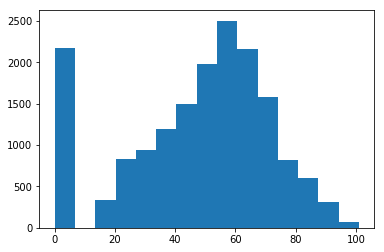

In [38]:
plt.hist(profile['age'], bins=15);

The data of `age` column looks exactly like you would expect. This histogram has a normal distribution with mean about 53-57 (if drop all 0s). Also, you can see at the left part of the histogram a tall bar. Of course, it's because of 0s which earlier was NaNs. Let's check what percent of all numbers 0s are. 

In [39]:
(profile['data_absent'] == 1).sum()/profile['data_absent'].shape[0]

0.12794117647058822

There're 12.8% of 0s in `profile`, so our histogram looks really reasonable. However, let's create an alternative version of `profile` with no 0s at all. This alternative data frame will be useful only in terms of our data analysis, but by this, we can have a much clear picture of real data in the original dataset.

In [40]:
#get indexes of rows with 0s
ind_to_drop = profile[profile['data_absent'] == 1].index

#create an alternative version of profile
profile_no_nan = profile.drop(ind_to_drop)

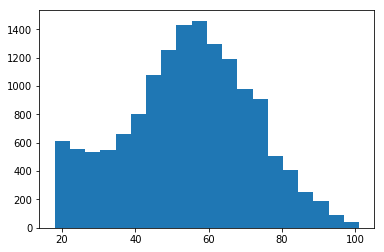

In [41]:
plt.hist(profile_no_nan['age'], bins=20);

In [42]:
profile_no_nan.age.median()

55.0

As we can see, we were absolutely right. The median is 55 indeed and the histogram still looks like the normal distribution, however, the shape of age distribution has changed a little bit and now we can see clearly that we have approximately the same count of users in the range from 18 to 40 years old

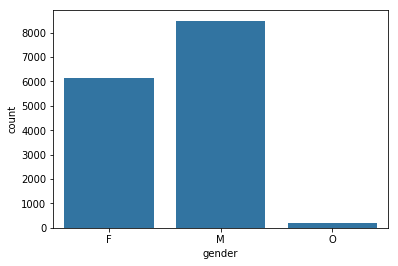

In [43]:
color = sb.color_palette()[0]
sb.countplot(profile_no_nan['gender'], color=color);

There is one third more men in our database than women.

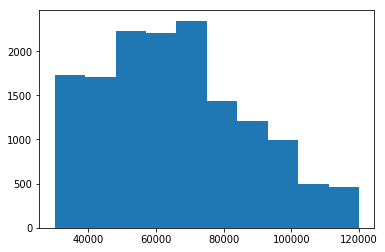

In [44]:
plt.hist(profile_no_nan['income']);

In [45]:
profile_no_nan.income.median()

64000.0

In [46]:
profile_no_nan.describe()

,age,income,data_absent
count,14825.000000,14825.000000,14825.0
mean,54.393524,65404.991568,0.0
std,17.383705,21598.299410,0.0
min,18.000000,30000.000000,0.0
25%,42.000000,49000.000000,0.0
50%,55.000000,64000.000000,0.0
75%,66.000000,80000.000000,0.0
max,101.000000,120000.000000,0.0


Histogram of income looks pretty interesting. Despite the left part of the histogram, I can say that the histogram is right skewed. The special thing about the left part is that we can see that there's approximately the same count of users in the range from 30k to 50k income, so it's not a classic case for the right skewed histogram, but I think that it's acceptable when we talking about real world data.

## Data Preparation
Now our data looks clean enough and we can become prepare it for the future machine learning process

As was said in the beginning, a user can receive an offer, never actually view the offer, and still complete the offer. So we need to avoid such things.

First of all, it means that we don't really care when the user received	the offer, hence we can drop all rows in `transcript` with "offer received". Also, it's obvious that we want to train and test our model only on the offers that were vied by user otherwise it just doesn't make any sense. Hence we need to drop all from `transcript` all rows with received but unviewed offers.

It's not obvious how we actually can use `became_member_on` column in `profile`. So, I think that it would be great to change the value of the date to the whole number, which will represent how many months/seasons/years ago did this customer became a member. However, I don't know what unit of time we should choose here. So, maybe we should create three versions of the solution and test each of them.

Moreover, we need to create dummy columns for all categorical values and make scaling for all numeric (not boolean) columns and combine all of this to one table.

So, here's the list of things that we need to do:

- Drop from `transcript` rows with value "offer received"
- Create one combined table
- Change the value of the date to the whole number, which will represent how many months/seasons/years ago did this the customer became a member
- Solve the problem with unviewed completed offers
- Create dummy columns for all categorical values
- Make scaling for all numeric columns

We need to create `channel` dummy columns separately from other dummies since values in `channel` represented by list and we need to work with it in a different way

In [47]:
#list of all kinds of channels
list_of_channels = ['web', 'email', 'mobile', 'social']

for chennel in list_of_channels:
    channel_bool = [] #list of future values of dummy columns

    for ind in range(portfolio.shape[0]):

        #check does the offer used a specific channel
        if chennel in portfolio.iloc[ind].channels: 
            channel_bool.append(1)
        else:
            channel_bool.append(0)

    #create a dummy column with the name of the channel
    portfolio[chennel + '_channel'] = channel_bool

#remove the `channels` column, we won't need it anymore
portfolio.drop('channels', axis=1 ,inplace=True)

Drop from `transcript` rows with value "offer received"

In [48]:
ind_to_drop = transcript[transcript['event'] == "offer received"].index
transcript.drop(ind_to_drop, inplace=True)

Process of creating one combined table will go through all of the "Data Preparation" section

Change the value of the date to the whole number, which will represent how many months/seasons/years ago did this customer became a member

In [49]:
def date_to_whole_number(df, whole_days, col_name='became_member_on', new_col_name='became_member_on'):
    '''
    Change the value of the date to the whole number, 
    which will represent how many equal intervals 
    in days ago did this date was
    
    df - dataframe
    whole_days - number equal intervals in days
    col_name - name of the column with the date
    new_col_name - new name for the col_name
    '''
    res = df.copy() 
    today = pd.to_datetime('today')
    
    became_member_on_diff = (today - res[col_name]) // whole_days
    res[col_name] = became_member_on_diff.astype(str).str.split(' ').str[0]
    
    if new_col_name != col_name:
        res.rename(columns={'became_member_on' : new_col_name}, inplace=True)
    
    return res


In [50]:
#Create three versions combined table
df1 = date_to_whole_number(profile, 30, new_col_name='is_client_in_months')
df2 = date_to_whole_number(profile, 90, new_col_name='is_client_in_seasons')
df3 = date_to_whole_number(profile, 365, new_col_name='is_client_in_years')

In [51]:
#check
df1.head()

,age,is_client_in_months,gender,id,income,data_absent
0,0.0,28,0,68be06ca386d4c31939f3a4f0e3dd783,0.0,1
1,55.0,23,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,0.0,11,0,38fe809add3b4fcf9315a9694bb96ff5,0.0,1
3,75.0,25,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,0.0,22,0,a03223e636434f42ac4c3df47e8bac43,0.0,1


In [52]:
#check
df2.head()

,age,is_client_in_seasons,gender,id,income,data_absent
0,0.0,9,0,68be06ca386d4c31939f3a4f0e3dd783,0.0,1
1,55.0,7,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,0.0,3,0,38fe809add3b4fcf9315a9694bb96ff5,0.0,1
3,75.0,8,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,0.0,7,0,a03223e636434f42ac4c3df47e8bac43,0.0,1


In [53]:
#check
df3.head()

,age,is_client_in_years,gender,id,income,data_absent
0,0.0,2,0,68be06ca386d4c31939f3a4f0e3dd783,0.0,1
1,55.0,1,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,0.0,0,0,38fe809add3b4fcf9315a9694bb96ff5,0.0,1
3,75.0,2,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,0.0,1,0,a03223e636434f42ac4c3df47e8bac43,0.0,1


Solve the problem with unviewed completed offers

In [54]:
transcript

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer_id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.83}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer_id': '5a8bc65990b245e5a138643cd4eb9837'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}


In [55]:
#dict of the form {'customer_id' : {'offer_id' : offer_status}}
customers_offers_status = {}

#going through all unique customers ids
for customer in tqdm(profile.id.unique()):
    curtomer_actions = transcript[transcript['person']==customer]
    
    #dict of the form {'offer_id' : offer_status}
    offers_status = {}
    
    #check does the event not a "transaction"
    for ind in curtomer_actions.index:
        try:
            offer_id = transcript.value[ind]['offer_id']
        except:
            continue
        
        #if we hadn't met the offer until now
        if offer_id not in offers_status:
            
            #the customer viewed the offer
            if transcript.event[ind] == 'offer viewed':
                offers_status[offer_id] = 0
    
            #the customer hadn't viewed the offer and it had finished
            elif transcript.event[ind] == 'offer completed':
                offers_status[offer_id] = -1
        
        #the customer completed the offer and he knows it
        elif transcript.event[ind] == 'offer completed':
            offers_status[offer_id] = 1
    
    #append results to final dict
    customers_offers_status[customer] = offers_status

100%|██████████| 17000/17000 [06:29<00:00, 43.62it/s]


In [56]:
#create dataframe with ids
df_ids = pd.DataFrame(customers_offers_status)

#check results
df_ids.head()

,68be06ca386d4c31939f3a4f0e3dd783,0610b486422d4921ae7d2bf64640c50b,38fe809add3b4fcf9315a9694bb96ff5,78afa995795e4d85b5d9ceeca43f5fef,a03223e636434f42ac4c3df47e8bac43,e2127556f4f64592b11af22de27a7932,8ec6ce2a7e7949b1bf142def7d0e0586,68617ca6246f4fbc85e91a2a49552598,389bc3fa690240e798340f5a15918d5c,8974fc5686fe429db53ddde067b88302,...,79edb810789c447e8d212a324b44cc16,a9a20fa8b5504360beb4e7c8712f8306,400d0536e8794cbb855b0d882d67cbda,cb23b66c56f64b109d673d5e56574529,c02b10e8752c4d8e9b73f918558531f7,6d5f3a774f3d4714ab0c092238f3a1d7,2cb4f97358b841b9a9773a7aa05a9d77,01d26f638c274aa0b965d24cefe3183f,9dc1421481194dcd9400aec7c9ae6366,e4052622e5ba45a8b96b59aba68cf068
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,1.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0
2906b810c7d4411798c6938adc9daaa5,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,NaN,...,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN


In [57]:
#create dataframe with info about customer id, offer id and offer status
df_offer_status = pd.DataFrame(columns=['id', 'offer_id', 'offer_status'])

#going through customers
for customer in tqdm(df_ids.columns):
    
    #going through offers
    for offer_id in range(len(df_ids[customer].index)):
        
        #if offer status isn't -1
        #(what means that the customer viewed the offer at least)
        if df_ids[customer][offer_id] >= 0:
            
            #append data to df_offer_status
            df_offer_status = df_offer_status.append(pd.DataFrame({'id' : [customer], 
                                                                   'offer_id' : [df_ids.index[offer_id]], 
                                                                   'offer_status' : [df_ids[customer][offer_id]]}))

100%|██████████| 17000/17000 [01:35<00:00, 177.84it/s]


In [58]:
#check
df_offer_status.head()

,id,offer_id,offer_status
0,68be06ca386d4c31939f3a4f0e3dd783,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
0,68be06ca386d4c31939f3a4f0e3dd783,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,0.0
0,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,1.0
0,38fe809add3b4fcf9315a9694bb96ff5,5a8bc65990b245e5a138643cd4eb9837,0.0


The function below intended to merge `df_offer_status` with all versions of df. Also, it intends to solve these two problems too:
- Create dummy columns for all categorical values
- Make scaling for all numeric columns

In [59]:
#list of all numeric column, except "is_client_in..." columns
numerical = ['age', 'income', 'difficulty', 'duration', 'reward']

#define scalar
scaler = MinMaxScaler()

def df_prepare(df, numerical_list=numerical, scaler=scaler, df_offer_status=df_offer_status):
    '''
    Function for final data preparation
    
    df - data frame we want to prepare
    numerical_list - list of numberical columns in df
    scaler - scaler for scaling numbers from numerical_list
    df_offer_status - data frame containing offer statuses
    '''    
    #merge with df_offer_status
    df = pd.merge(df, df_offer_status, on='id') 
    df = pd.merge(df, portfolio, left_on='offer_id', right_on='id')
    
    #drop of unuseful columns
    df.drop(['id_x', 'offer_id', 'id_y'], axis=1, inplace=True)
    
    #column, which will represent how many months/seasons/years ago did this customer became a member
    is_client_in_col = [df.columns[1]]
    
    #scale numerical columns
    df[numerical_list] = scaler.fit_transform(df[numerical_list])
    df[is_client_in_col] = scaler.fit_transform(df[is_client_in_col])
    
    #create dummy columns for all categorical values
    df = df.join(pd.get_dummies(df['gender'], prefix='gender_'))
    df = df.join(pd.get_dummies(df['offer_type'], prefix='offer_type_'))
    
    df.drop(['gender', 'gender__0', 'offer_type'], axis=1, inplace=True)
    
    return df

In [60]:
#merge dfs with df_offer_status
df1 = df_prepare(df1)
df2 = df_prepare(df2)
df3 = df_prepare(df3)

In [61]:
#check
df1.head()

,age,is_client_in_months,income,data_absent,offer_status,difficulty,duration,reward,web_channel,email_channel,mobile_channel,social_channel,gender__F,gender__M,gender__O,offer_type__bogo,offer_type__discount
0,0.000000,0.295082,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1
1,0.000000,0.196721,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1
2,0.603960,0.180328,0.475000,0,0.0,1.0,1.0,0.375,1,1,0,0,1,0,0,0,1
3,0.613861,0.491803,0.591667,0,0.0,1.0,1.0,0.375,1,1,0,0,1,0,0,0,1
4,0.000000,0.196721,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1


In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37121 entries, 0 to 37120
Data columns (total 17 columns):
age                     37121 non-null float64
is_client_in_months     37121 non-null float64
income                  37121 non-null float64
data_absent             37121 non-null int64
offer_status            37121 non-null float64
difficulty              37121 non-null float64
duration                37121 non-null float64
reward                  37121 non-null float64
web_channel             37121 non-null int64
email_channel           37121 non-null int64
mobile_channel          37121 non-null int64
social_channel          37121 non-null int64
gender__F               37121 non-null uint8
gender__M               37121 non-null uint8
gender__O               37121 non-null uint8
offer_type__bogo        37121 non-null uint8
offer_type__discount    37121 non-null uint8
dtypes: float64(7), int64(5), uint8(5)
memory usage: 5.1 MB


In [63]:
#check
df2.head()

,age,is_client_in_seasons,income,data_absent,offer_status,difficulty,duration,reward,web_channel,email_channel,mobile_channel,social_channel,gender__F,gender__M,gender__O,offer_type__bogo,offer_type__discount
0,0.000000,0.3,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1
1,0.000000,0.2,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1
2,0.603960,0.2,0.475000,0,0.0,1.0,1.0,0.375,1,1,0,0,1,0,0,0,1
3,0.613861,0.5,0.591667,0,0.0,1.0,1.0,0.375,1,1,0,0,1,0,0,0,1
4,0.000000,0.2,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1


In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37121 entries, 0 to 37120
Data columns (total 17 columns):
age                     37121 non-null float64
is_client_in_seasons    37121 non-null float64
income                  37121 non-null float64
data_absent             37121 non-null int64
offer_status            37121 non-null float64
difficulty              37121 non-null float64
duration                37121 non-null float64
reward                  37121 non-null float64
web_channel             37121 non-null int64
email_channel           37121 non-null int64
mobile_channel          37121 non-null int64
social_channel          37121 non-null int64
gender__F               37121 non-null uint8
gender__M               37121 non-null uint8
gender__O               37121 non-null uint8
offer_type__bogo        37121 non-null uint8
offer_type__discount    37121 non-null uint8
dtypes: float64(7), int64(5), uint8(5)
memory usage: 5.1 MB


In [65]:
#check
df3.head()

,age,is_client_in_years,income,data_absent,offer_status,difficulty,duration,reward,web_channel,email_channel,mobile_channel,social_channel,gender__F,gender__M,gender__O,offer_type__bogo,offer_type__discount
0,0.000000,0.4,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1
1,0.000000,0.2,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1
2,0.603960,0.2,0.475000,0,0.0,1.0,1.0,0.375,1,1,0,0,1,0,0,0,1
3,0.613861,0.6,0.591667,0,0.0,1.0,1.0,0.375,1,1,0,0,1,0,0,0,1
4,0.000000,0.2,0.000000,1,0.0,1.0,1.0,0.375,1,1,0,0,0,0,0,0,1


In [66]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37121 entries, 0 to 37120
Data columns (total 17 columns):
age                     37121 non-null float64
is_client_in_years      37121 non-null float64
income                  37121 non-null float64
data_absent             37121 non-null int64
offer_status            37121 non-null float64
difficulty              37121 non-null float64
duration                37121 non-null float64
reward                  37121 non-null float64
web_channel             37121 non-null int64
email_channel           37121 non-null int64
mobile_channel          37121 non-null int64
social_channel          37121 non-null int64
gender__F               37121 non-null uint8
gender__M               37121 non-null uint8
gender__O               37121 non-null uint8
offer_type__bogo        37121 non-null uint8
offer_type__discount    37121 non-null uint8
dtypes: float64(7), int64(5), uint8(5)
memory usage: 5.1 MB


## Machine learning

Finally, we have completed the preparation of our date invoice and can begin to train our model. First of all, we need to choose an algorithm that we will use to train the model. We must conduct certain tests in order to choose the model that is optimal for our task. The test will look like the following: we will choose several ML models and one version of df, after which we will first train the model and compare the speed and the result of the model’s training on each model with limited training data to 100, 1k and 10k rows.

After, we will train the chosen model on three versions of df and then we'll choose the one with the bast predicting results. 

In the final of "Machine learning" section, we will improve the chosen ML model by grid search.

I chose f1 score for model scoring since we need to predict a binary variable, so I had three main metrics to score my model: accuracy, f1, f_beta. I decided not to choose accuracy since it's a less useful method of measurement than f1/f_beta for most of the cases and I can't say what time of error we want to minimize in our model, so f_beta is not the best chose too. Hence I've chosen f1.

In [67]:
#split df to train/test

#for choosing ML algorithm we will use the only df1
#comparing results of df1 with the other two versions
#would be the next step

y = df1['offer_status']
X = df1.drop('offer_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

I've chosen the following models: 
- SVC
- AdaBoostClassifier
- RandomForestClassifier
- MLPClassifier

In [68]:
#models definition
learner_A = SVC(random_state=42)
learner_B = AdaBoostClassifier(random_state=42)
learner_C = RandomForestClassifier(random_state=42)
learner_D = MLPClassifier(random_state=42)

learners_list = learner_A, learner_B, learner_C, learner_D
sample_sazes = [100, 1000, 10000]

#lists which will mould the data frame with
#experimaent results later
learner_list = []
f1_score_list = []
time_spent_list = []

for learner in learners_list:
    for size in sample_sazes:
        
        #take the name of the algorithm
        learner_name = str(type(learner)).split('.')[-1][:-2]
        learner_list.append(learner_name)
        
        #training of the model and noting the time
        start = time()
        learner = learner.fit(X_train[:size], y_train[:size])
        stop = time()
        time_spent_list.append(stop - start)
        
        #predicting and scoring
        pred_res = learner.predict(X_test)
        f1 = f1_score(pred_res, y_test)
        f1_score_list.append(f1)
        
#moulding of the data frame with results
df_ML = pd.DataFrame({'model' : learner_list,
                      'size' : sample_sazes * 4,
                      'f1_score' : f1_score_list,
                      'time_spent' : time_spent_list})

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [69]:
#check results
df_ML

,model,size,f1_score,time_spent
0,SVC,100,0.782454,0.003158
1,SVC,1000,0.794276,0.047802
2,SVC,10000,0.793268,5.363967
3,AdaBoostClassifier,100,0.707821,0.071144
4,AdaBoostClassifier,1000,0.787921,0.098883
5,AdaBoostClassifier,10000,0.791328,0.397282
6,RandomForestClassifier,100,0.722508,0.017379
7,RandomForestClassifier,1000,0.748492,0.023498
8,RandomForestClassifier,10000,0.761484,0.118098
9,MLPClassifier,100,0.771844,0.118139


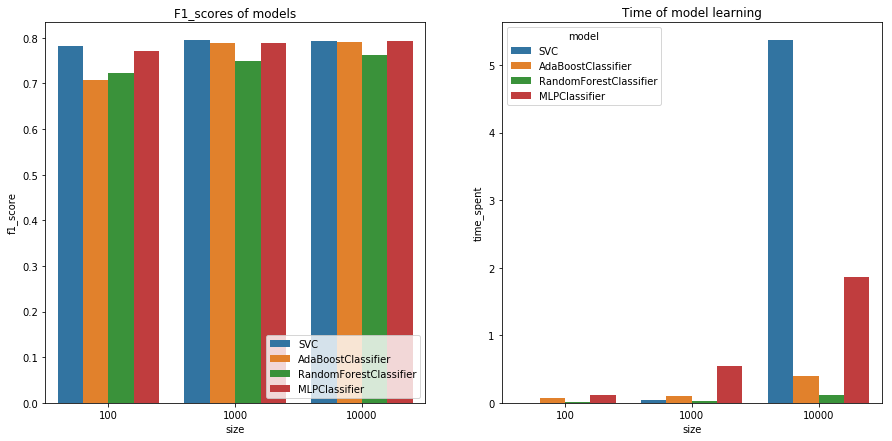

In [70]:
#creating visualisation of the experimaent
plt.subplots(1, 2, figsize=(15,7));

plt.subplot(1, 2, 1)
sb.barplot(data=df_ML, x='size', y='f1_score', hue='model', )
plt.title('F1_scores of models')
plt.legend(loc=4)

plt.subplot(1, 2, 2)
sb.barplot(data=df_ML, x='size', y='time_spent', hue='model')
plt.title('Time of model learning');

We've got very interesting results. Two models with the best f1 results are AdaBoostClassifier and MLPClassifier. MLPClassifier has a bit better results, but AdaBoostClassifier looks much faster. So, I think that the best decision here is to choose AdaBoostClassifier.

Now we need to choose the best version of the prepared data set. I will train models on these three versions and will compere their f1 results.

In [71]:
model = AdaBoostClassifier(random_state=42)
df_list = df1, df2, df3

names = ['df1', 'df2', 'df3']
f1_score_list = []

for df in df_list:
    y = df['offer_status']
    X = df.drop('offer_status', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    model = model.fit(X_train, y_train)
    pred_res = model.predict(X_test)
    
    f1 = f1_score(pred_res, y_test)
    f1_score_list.append(f1)
        
df_versions = pd.DataFrame({'model' : names,
                            'f1_score' : f1_score_list})

In [72]:
#check results
df_versions

,model,f1_score
0,df1,0.790743
1,df2,0.792499
2,df3,0.788118


It seems that `df2` has a bit better result than others, but actually, it doesn't mean that it always be the case. However, I've decided to pick `df2`

In [75]:
y = df2['offer_status']
X = df2.drop('offer_status', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

parameters = {'learning_rate' : np.arange(1, 2, 0.01), 'n_estimators' : np.arange(1, 10, 1)}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(model, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (model.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [76]:
before_grid = round(f1_score(y_test, predictions), 4) * 100
after_grid = round(f1_score(y_test, best_predictions), 4) * 100

print('F1 before grid search: {}% \nF1 after grid search: {}%'.format(before_grid, after_grid))

F1 before grid search: 79.25% 
F1 after grid search: 80.03%


As we can see grid search helped us to improve our model a bit further. Now we have 80% in the f1 score which seems a pretty good result.

## Conclusion

### Justification & Improvement

The main idea of this project was to create a useful tool, which can be used by another script to send customers offers which they almost certainly will like. The model now looks good and I think that we actually can use it for a test. 

However, these results still don't look like the final tool, I think. Actually, there're still a lot of things that can be improved, I think. First of all, there's always some space for experiments, maybe we can try some other ML models, maybe we can experiment with parameters of the model to do it better, maybe we can try other methods of preparing our data. For example, we can divide people into groups by income, age and etc. I think that there's some probability that all these experiments, mentioned earlier can make our results better. 

One more thing about further improvement. I think that we can improve this model if we will detect how close the customer was to completion of the offer. For example, we can have some group of people who really were interested in an offer, but for some reasons, they did not have enough time to complete it. Our current model doesn't check such things for now. I think that such improvement can make this model better, but, of course, it's not for sure, so there's also some space for experiments.

### Reflection

A comprehensive solution to the problem consists in combining all the tables so that each row is a potentially interesting event for us. In this case, the line should contain all potentially useful information about the user and the offeror. This part of the project was the most difficult since the association of tables with the necessary images in this particular case was not trivial. Then there were quite standard steps: creating dummies columns, scaling, model selection and training.